In [163]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-scoring/sample_submission.csv
/kaggle/input/sf-dst-scoring/train.csv
/kaggle/input/sf-dst-scoring/test.csv


# Описание данных:
    
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [164]:
from pandas import Series
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

Функции используемые в работе

In [165]:
# Функция построения боксплотов
def get_boxplot(col_x, col_y):
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.boxplot(x=col_x, y=col_y, data=data[
        data['sample'] == 1])  # берем данные только по обучаемой выборке
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + col_y)
    plt.show()


# Функция расчета межквартильных параметров
def get_stat(col):
    median = data[col].median()
    IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
    perc25 = data[col].quantile(0.25)
    perc75 = data[col].quantile(0.75)
    print(
        '25-percentile: {},'.format(perc25),
        '75-percentile: {},'.format(perc75), "IQR: {}, ".format(IQR),
        "Interquartile range: [{f}, {l}].".format(f=perc25 - 1.5 * IQR,
                                                  l=perc75 + 1.5 * IQR))


# Функция расчета метрик
def count_metrics(y_test, y_pred, y_probs):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_test, y_pred)
    metrics['f1'] = f1_score(y_test, y_pred)
    metrics['roc_auc'] = roc_auc_score(y_test, y_probs)
    metrics['confusion'] = confusion_matrix(y_test, y_pred)
    return metrics


# Функция построения ROC AUC
def show_roc_auc(y_test, y_probs):
    fpr, tpr, threshold = roc_curve(y_test, y_probs)
    roc_auc = roc_auc_score(y_test, y_probs)
    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Изучение данных

In [166]:
path = '/kaggle/input/sf-dst-scoring/'
train = pd.read_csv(path +'/train.csv')
test = pd.read_csv(path +'test.csv')
sample_sub = pd.read_csv(path +'/sample_submission.csv')
train.info()
print('Размер обучаемой выборки', train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [167]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
71865,66673,15MAR2014,GRD,F,66,N,N,0,0,-2.730227,0,50,2,3,25000,1,4,N,0
25293,27969,04FEB2014,GRD,M,29,Y,Y,0,1,-2.945873,3,60,2,3,35000,4,4,N,0
67319,22832,30JAN2014,SCH,F,35,N,N,0,0,-2.221400,2,50,1,2,20000,4,1,N,0
55864,3007,09JAN2014,SCH,F,43,Y,N,0,0,-1.875588,1,50,1,1,16000,1,3,N,0
52485,53669,02MAR2014,SCH,F,24,N,N,0,0,-2.225004,3,50,2,3,15000,4,1,N,0


In [168]:
test.info()
print('Размер тестовой выборки', test.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [169]:
test.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [170]:
sample_sub.info()
print(sample_sub.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB
(24354, 2)


In [171]:
sample_sub.head(5)

,client_id,default
0,66799,0.441004
1,25379,0.138092
2,28825,0.373370
3,37530,0.476501
4,4264,0.304640


<AxesSubplot:xlabel='default', ylabel='count'>

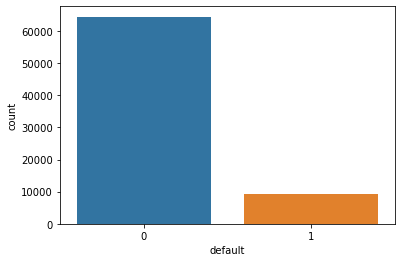

In [172]:
# Распределение признака default на обучаемой выборке
sns.countplot(x='default', data=train)

Распределение не равномерное, много кредитов выдается

Для удобства объеденим обучаемую и тестовую выборки.

In [173]:
# Для определения обучаемой и тестовой выборки создадим колонки со значениями 1 и 0
train['sample'] = 1  # обучаемая выборка
test['sample'] = 0  # тестовая выборка
# т.к. изначально нет занчения default в тестовой выборке создаем колонку со значением -1
test['default'] = -1
data = train.append(test, sort=False).reset_index(drop=True)

In [174]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [175]:
data.shape

(110148, 20)

Посмотрим на наличие пустых полей

In [176]:
data.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
sample                0
dtype: int64

# Визуализация данных

In [177]:
display(data)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,31MAR2014,SCH,F,37,N,N,1,0,-1.744976,3,50,2,3,15000,4,1,N,-1,0
110144,106254,25APR2014,GRD,F,64,Y,Y,0,0,-2.293781,3,60,1,2,200000,1,4,N,-1,0
110145,81852,30MAR2014,GRD,M,31,N,N,2,0,-0.940752,1,50,1,2,60000,4,2,N,-1,0
110146,1971,07JAN2014,UGR,F,27,N,N,1,0,-1.242392,2,80,2,3,30000,1,1,N,-1,0


Для удобства создаю списки для числовых, бинарных и категориальных колонок

In [178]:
#Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
#Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']
#Числовые переменные
num_cols = [
    'age', 'income', 'decline_app_cnt', 'bki_request_cnt', 'region_rating',
    'score_bki'
]

## Числовые переменные

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


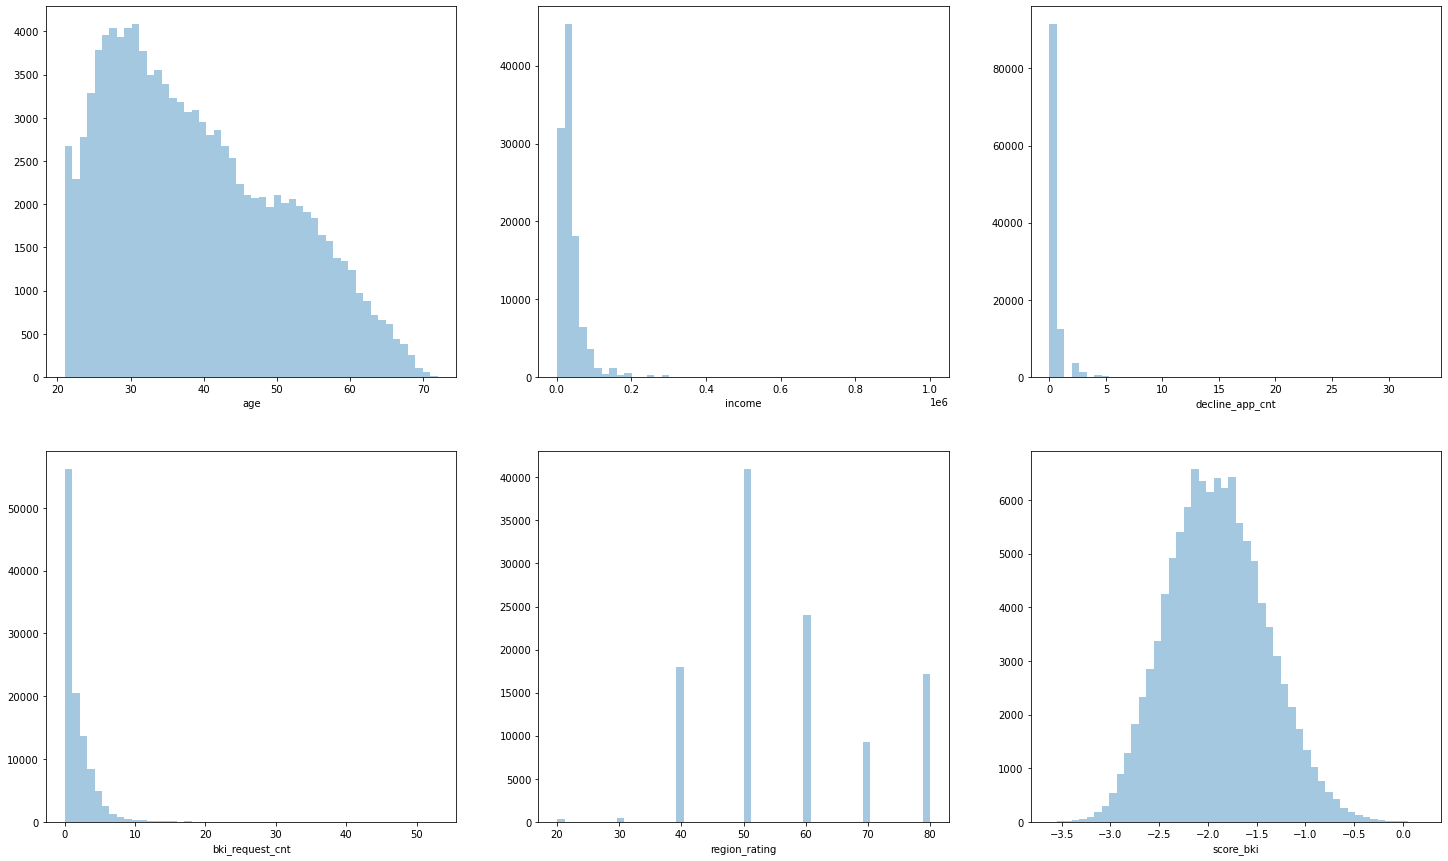

In [179]:
# Распределение числовых переменных
fig, axes = plt.subplots(2, 3, figsize=(25,15))

for i,col in enumerate(num_cols):
    sns.distplot(data[col], kde=False, ax=axes.flat[i])

Распределение разное. Построим график логарифмов менее неравномерных переменных

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

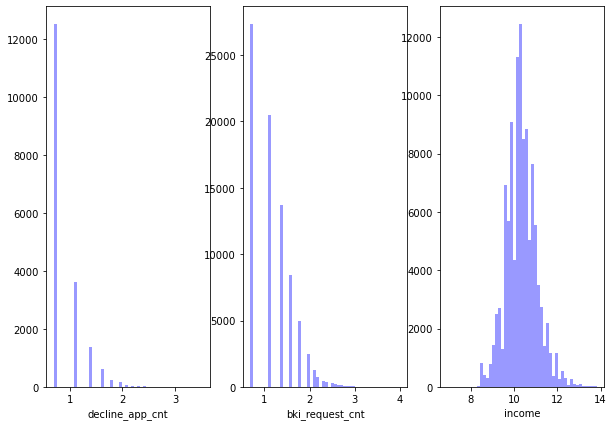

In [180]:
fig, axes = plt.subplots(1, 3, figsize=(10, 7))
for i, col in enumerate(['decline_app_cnt', 'bki_request_cnt', 'income']):
    data[col] = np.log(data[col] + 1)
    sns.distplot(data[col][data[col] > 0].dropna(),
                 ax=axes.flat[i],
                 kde=False,
                 rug=False,
                 color="b")

Лучше видны выбросы. Построим боксплоты для числовых переменных.

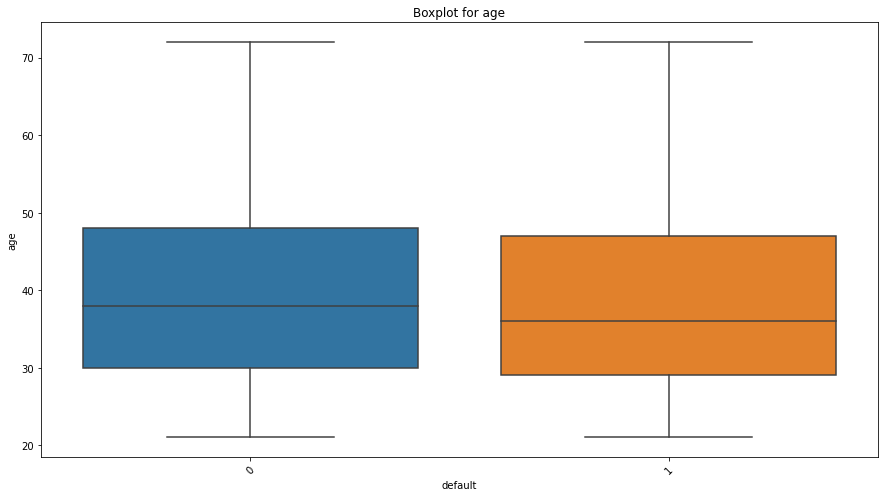

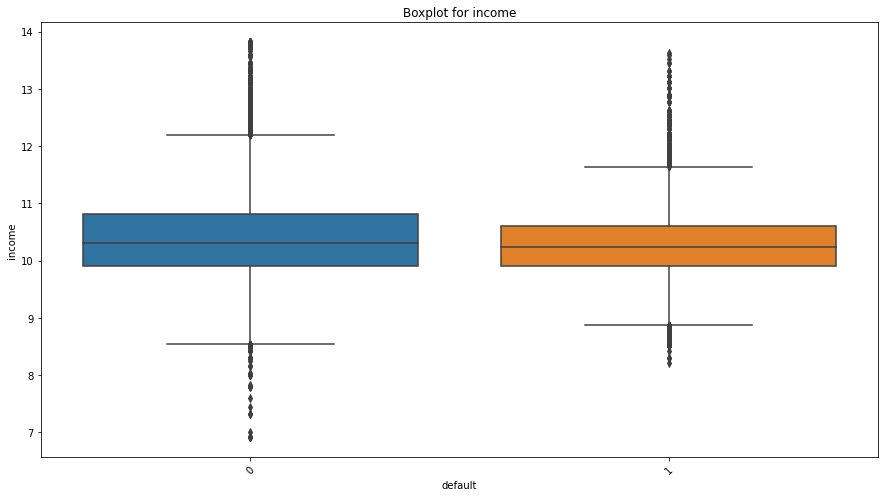

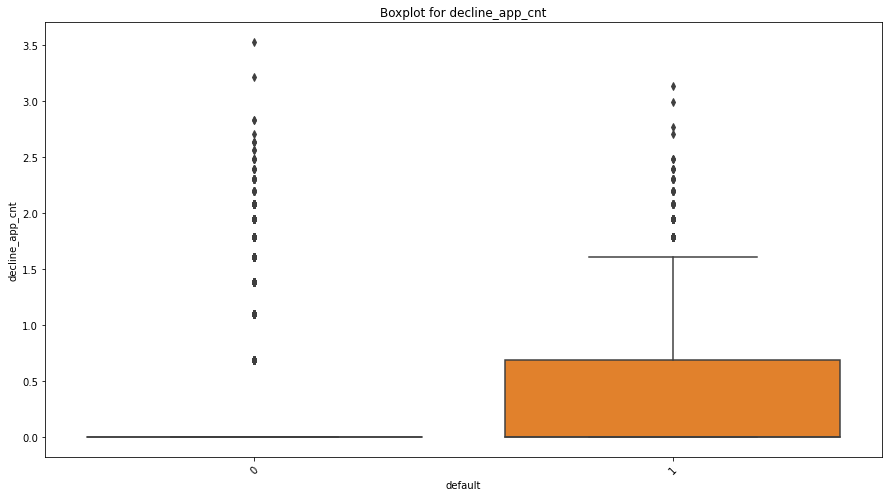

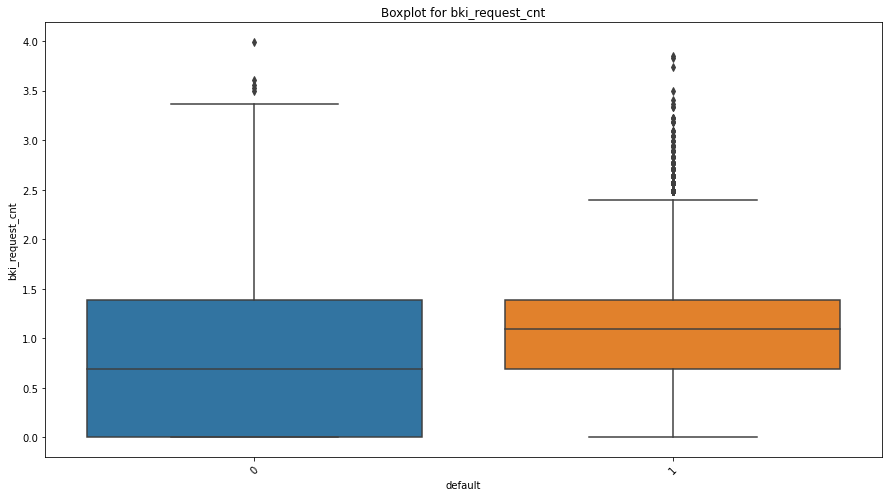

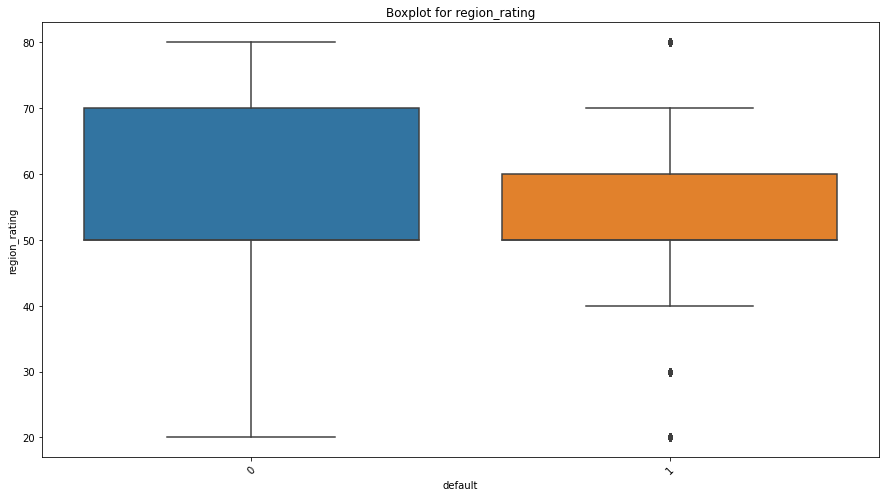

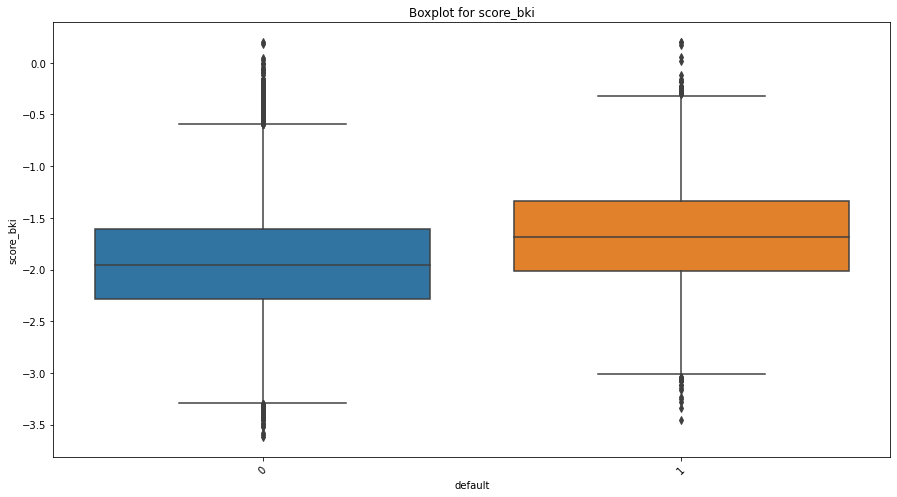

In [181]:
for col in num_cols:
    get_boxplot('default', col)

1) Дефолтные клиенты моложе;

2) У них больше отказов по кредитам;

3) У них больше запросов в БКИ;

4) У них меньший доход;

5) Для дефолтных заемщиков оценка выше;

6) Рейтинг региона влияет на положительный ответ по кредиту


## Категориальные переменные

<AxesSubplot:>

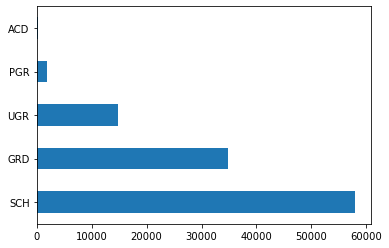

In [182]:
# Посмотрим на уровень образования
data['education'].value_counts().plot.barh()

In [183]:
# проверим пустые поля
data['education'].isna().value_counts()

False    109670
True        478
Name: education, dtype: int64

Заменим пустые значения на самое рапространенное 'SCH'

In [184]:
data['education'] = data['education'].fillna('SCH')
data['education'].isna().value_counts()

False    110148
Name: education, dtype: int64

Проверим зависимость дохода от уровня образования

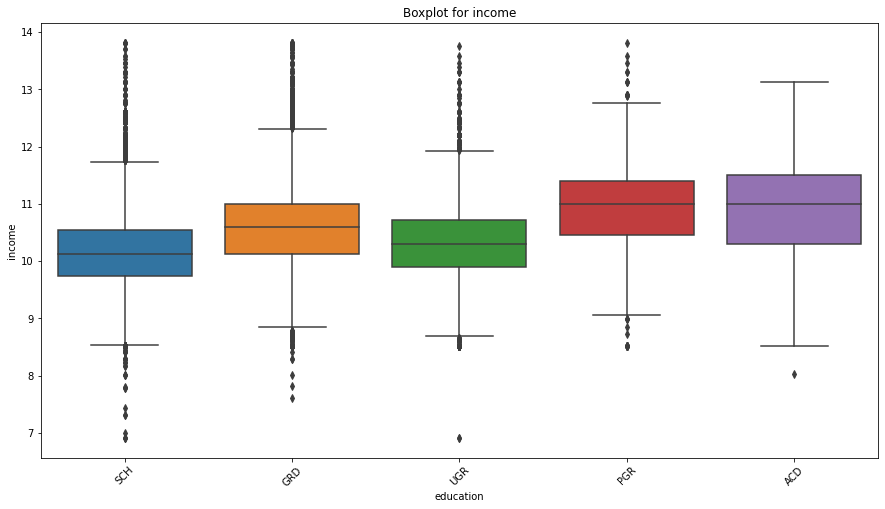

In [185]:
get_boxplot('education', 'income')

Чем выше образование, тем выше доход

Посмотрим на зависимость рейтинга региона от скорингового балла по данным из БКИ

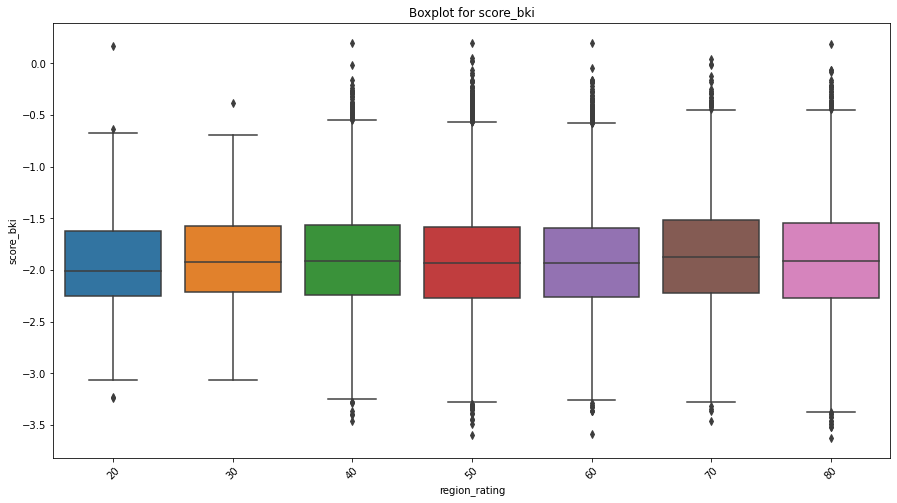

In [186]:
get_boxplot('region_rating', 'score_bki')

Зависимость примерно одинаковая

Посмотрим зависимость образования от возраста

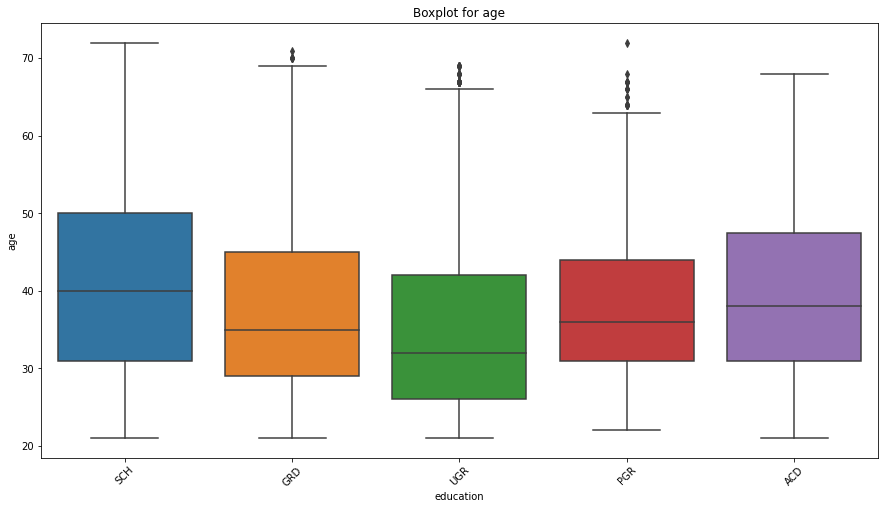

In [187]:
get_boxplot('education', 'age')

Распределение уровня образования по взрастам примерно одинаково. Заметно что более молодые люди имеют уровень образования UGR - скорее всего undergraduate, т.е. уровень бакалавриата

## Бинарные переменные

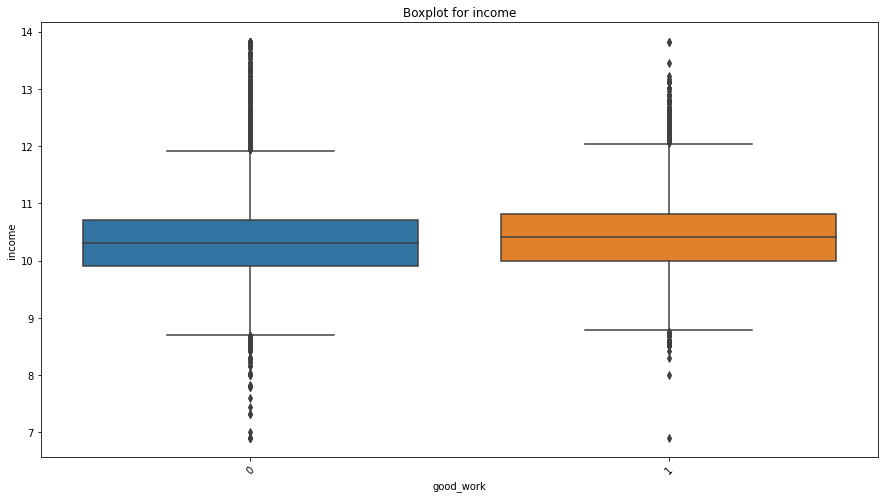

In [188]:
get_boxplot('good_work', 'income')

Наличие хорошей работы дает в среднем больший доход

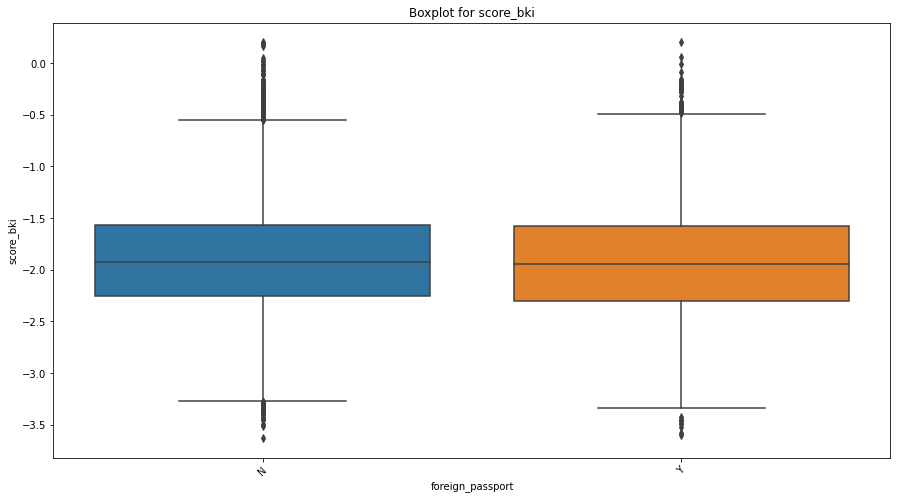

In [189]:
get_boxplot('foreign_passport', 'score_bki')

Владельцы загранпаспорта имеют немного более высокий скоринг из БКИ

Оценим корреляцию Пирсона для непрерывных переменных

<AxesSubplot:>

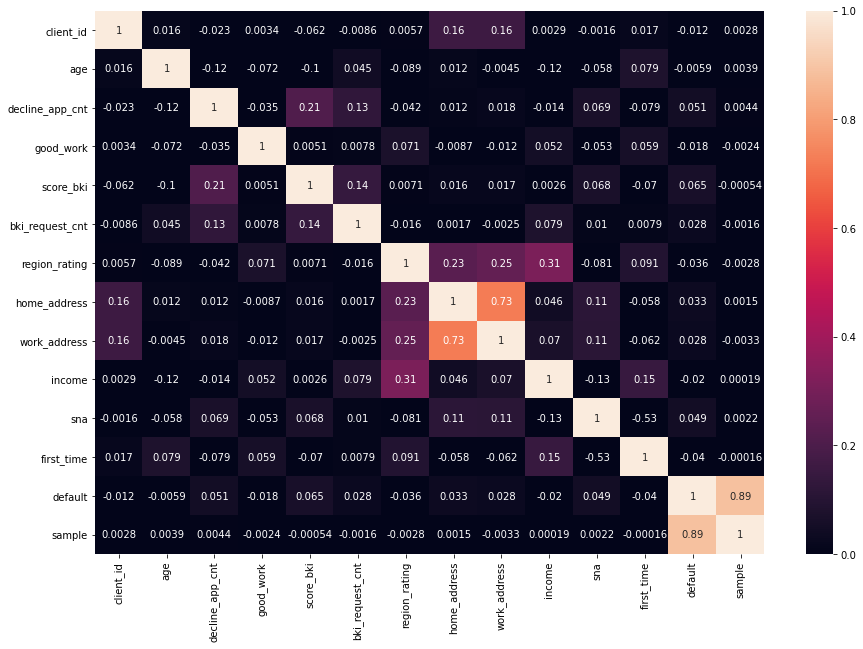

In [190]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.corr(), vmin=0, vmax=1, annot = True)

Сильно коррелирующих переменных практически нет, кроме домашнего и рабочего адресов. Налюдаются также зависимости между рейтингом региона и доходом, домашним и рабочим адресами.

# EDA and feature engineering

Посмотрим на колонку с датами

In [191]:
data['app_date'] = pd.to_datetime(data.app_date)
data['app_date'].sample(5)

91506   2014-02-02
73081   2014-01-30
20478   2014-01-22
74656   2014-02-26
62630   2014-03-19
Name: app_date, dtype: datetime64[ns]

Заменим колонку с датами на разницу между текущей датой и самой первой датой в датасете

In [192]:
data['app_date'] = data['app_date'].apply(lambda x:
                                          (x - data['app_date'].min()).days)

In [193]:
data['app_date'].sample(5)

43046    78
73097    95
12451    55
62223    21
47282    56
Name: app_date, dtype: int64

Поработаем с доходом.

Создадим три признака: средний доход по возрасту, максимальный доход по возрасту и нормальзованый доход по возрасту.

In [194]:
# средний доход по возрасту
mean_income = data.groupby('age')['income'].mean().to_dict()
data['mean_income_age'] = data['age'].map(mean_income).round(2)

In [195]:
# максимальный доход по возрасту
max_income = data.groupby('age')['income'].max().to_dict()
data['max_income_age'] = data['age'].map(max_income).round(2)

In [196]:
# Нормализуем
data["normalized_income"] = abs((data.income - data.mean_income_age)/data.max_income_age).round(2)

Создадим другой признак: средний уровень дохода в зависимости от рейтинга региона

In [197]:
mean_income_rat = data.groupby('region_rating')['income'].mean().to_dict()
data['mean_income_region'] = data['region_rating'].map(mean_income_rat).round(2)

Создадим еще два признака: среднее количество запросов в БКИ в зависимости от дохода и возраста

In [198]:
mean_bki = data.groupby('age')['bki_request_cnt'].mean().to_dict()
data['mean_requests_age'] = data['age'].map(mean_bki).round(2)

mean_bki_inc = data.groupby('income')['bki_request_cnt'].mean().to_dict()
data['mean_requests_income'] = data['income'].map(mean_bki_inc).round(2)

In [199]:
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,first_time,foreign_passport,default,sample,mean_income_age,max_income_age,normalized_income,mean_income_region,mean_requests_age,mean_requests_income
0,25905,31,SCH,M,62,Y,Y,0.000000,0,-2.008753,...,1,N,0,1,9.92,12.61,0.01,10.21,0.90,0.90
1,63161,70,SCH,F,59,N,N,0.000000,0,-1.532276,...,1,N,0,1,10.00,13.76,0.01,10.21,0.91,0.94
2,25887,31,SCH,M,25,Y,N,1.098612,0,-1.408142,...,4,Y,0,1,10.31,13.30,0.00,10.78,0.83,0.84
3,16222,22,SCH,F,53,N,N,0.000000,0,-2.057471,...,3,N,0,1,10.30,13.82,0.08,10.21,0.94,0.74
4,101655,107,GRD,M,48,N,N,0.000000,1,-1.244723,...,4,Y,0,1,10.41,13.71,0.01,10.28,0.95,0.84


# Подготовка данных к машинному обучению

Поработаем с бинарными и категориальными признаками используя LabelEncoder and OneHotEncoder

In [200]:
#  Бинарные переменные
mapped_data_binary = {}
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mapped_data_binary[col] = dict(enumerate(label_encoder.classes_))

In [201]:
mapped_data_binary

{'sex': {0: 'F', 1: 'M'},
 'car': {0: 'N', 1: 'Y'},
 'car_type': {0: 'N', 1: 'Y'},
 'good_work': {0: 0, 1: 1},
 'foreign_passport': {0: 'N', 1: 'Y'}}

In [202]:
#  Категориальные переменные
mapped_data_cat = {}
enc = OneHotEncoder()
for col in cat_cols:
    data[col] = label_encoder.fit_transform(data[col])
    mapped_data_cat[col] = dict(enumerate(label_encoder.classes_))

In [203]:
mapped_data_cat

{'education': {0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'},
 'home_address': {0: 1, 1: 2, 2: 3},
 'work_address': {0: 1, 1: 2, 2: 3},
 'sna': {0: 1, 1: 2, 2: 3, 3: 4},
 'first_time': {0: 1, 1: 2, 2: 3, 3: 4}}

Переназначим колонки

In [204]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   client_id             110148 non-null  int64  
 1   app_date              110148 non-null  int64  
 2   education             110148 non-null  int64  
 3   sex                   110148 non-null  int64  
 4   age                   110148 non-null  int64  
 5   car                   110148 non-null  int64  
 6   car_type              110148 non-null  int64  
 7   decline_app_cnt       110148 non-null  float64
 8   good_work             110148 non-null  int64  
 9   score_bki             110148 non-null  float64
 10  bki_request_cnt       110148 non-null  float64
 11  region_rating         110148 non-null  int64  
 12  home_address          110148 non-null  int64  
 13  work_address          110148 non-null  int64  
 14  income                110148 non-null  float64
 15  

In [205]:
# Числовые переменные
num_cols = [
    'age', 'decline_app_cnt', 'score_bki', 'income', 'bki_request_cnt',
    'app_date', 'mean_income_age', 'region_rating', 'max_income_age',
    'normalized_income', 'mean_requests_age', 'mean_requests_income',
    'mean_income_region'
]  
# категориальные переменные
cat_cols = ['education', 'work_address', 'home_address', 'sna',
            'first_time']  
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work',
            'foreign_passport']  

In [206]:
len(num_cols)

13

Проверим распределение числовых колонок

count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64

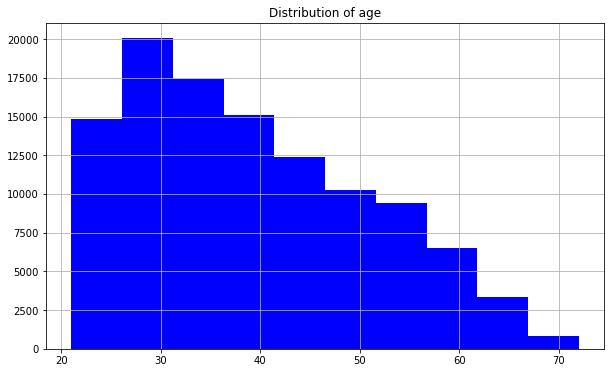

In [207]:
data.age.hist(color='b', figsize=(10,6))
plt.title('Distribution of age')
data.age.describe()

In [208]:
get_stat('age')

25-percentile: 30.0, 75-percentile: 48.0, IQR: 18.0,  Interquartile range: [3.0, 75.0].


Распределение несимметричное, смещено вправо. Выбросов нет.

count    110148.000000
mean          0.151330
std           0.361331
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           3.526361
Name: decline_app_cnt, dtype: float64

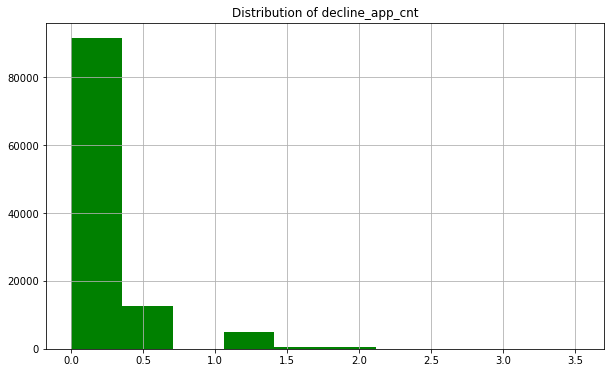

In [209]:
data.decline_app_cnt.hist(color='g', figsize=(10,6))
plt.title('Distribution of decline_app_cnt')
data.decline_app_cnt.describe()

In [210]:
get_stat('decline_app_cnt')

25-percentile: 0.0, 75-percentile: 0.0, IQR: 0.0,  Interquartile range: [0.0, 0.0].


Странный межквартильный интервал. Ничего делать с колонкой не будем.

count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64

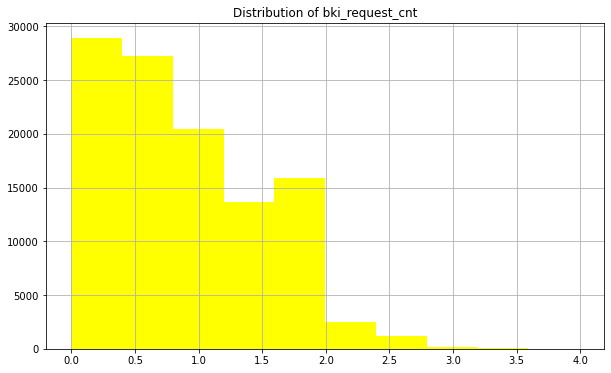

In [211]:
data.bki_request_cnt.hist(color='yellow', figsize=(10,6))
plt.title('Distribution of bki_request_cnt')
data.bki_request_cnt.describe()

In [212]:
get_stat('bki_request_cnt')

25-percentile: 0.0, 75-percentile: 1.3862943611198906, IQR: 1.3862943611198906,  Interquartile range: [-2.0794415416798357, 3.465735902799726].


Есть выбросы.  Удалим выбросы из обучаемой выборки.

In [213]:
data_temp = data.loc[data['sample'] == 1] # обучающая выборка

In [214]:
data_temp = data_temp.loc[data_temp['bki_request_cnt'].between(-2, 3.47)]

count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64

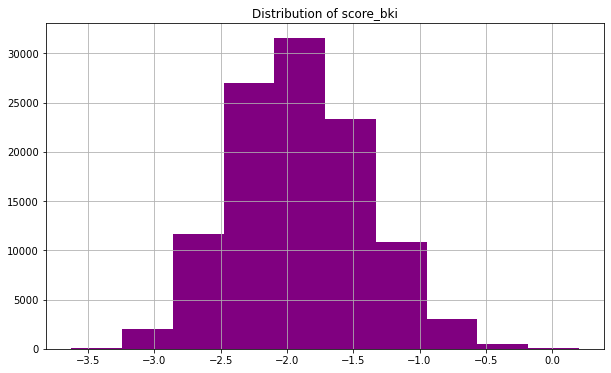

In [215]:
data.score_bki.hist(color='purple', figsize=(10,6))
plt.title('Distribution of score_bki')
data.score_bki.describe()

In [216]:
get_stat('score_bki')

25-percentile: -2.2604336700000003, 75-percentile: -1.5678881525, IQR: 0.6925455175000004,  Interquartile range: [-3.299251946250001, -0.5290698762499992].


Есть выбросы.  Удалим выбросы из обучаемой выборки.

In [217]:
data_temp = data_temp.loc[data_temp['score_bki'].between(-3.299, 0.529)]

> ## Значимость числовых признаков

<AxesSubplot:>

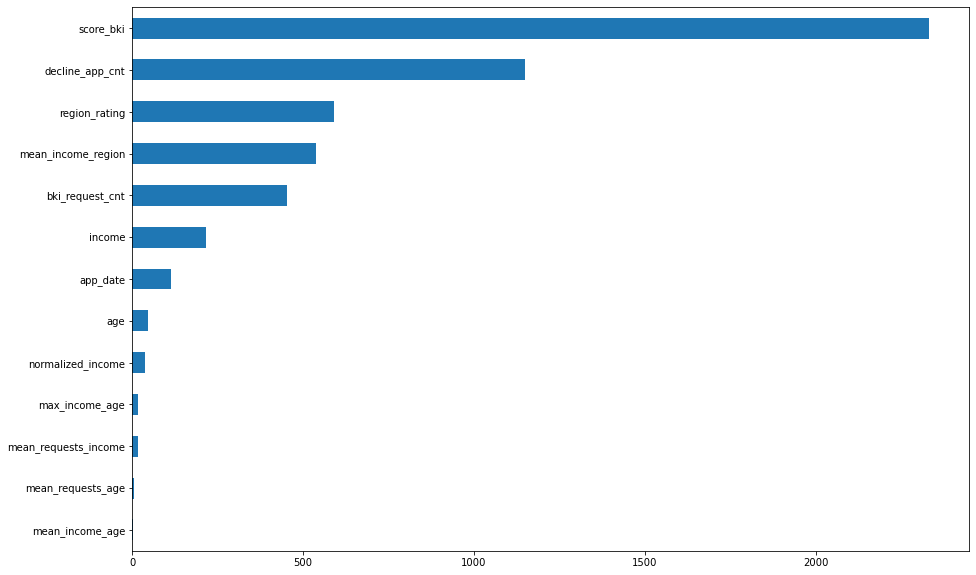

In [219]:
imp_num = pd.Series(f_classif(data_temp[num_cols], data_temp['default'])[0],
                    index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Нибольшую значимость дает score_bki. Из вновь созданных признаков какую-то значимость имеет mean_income_region.

## Значимость бинарных и категориальных признаков

In [220]:
# Для бинарных используем LabelEncoder

label_encoder = LabelEncoder()

for column in bin_cols:
    data_temp[column] = label_encoder.fit_transform(data_temp[column])
    
# Проверим трансформацию    
data_temp.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,first_time,foreign_passport,default,sample,mean_income_age,max_income_age,normalized_income,mean_income_region,mean_requests_age,mean_requests_income
0,25905,31,3,1,62,1,1,0.000000,0,-2.008753,...,0,0,0,1,9.92,12.61,0.01,10.21,0.90,0.90
1,63161,70,3,0,59,0,0,0.000000,0,-1.532276,...,0,0,0,1,10.00,13.76,0.01,10.21,0.91,0.94
2,25887,31,3,1,25,1,0,1.098612,0,-1.408142,...,3,1,0,1,10.31,13.30,0.00,10.78,0.83,0.84
3,16222,22,3,0,53,0,0,0.000000,0,-2.057471,...,2,0,0,1,10.30,13.82,0.08,10.21,0.94,0.74
4,101655,107,1,1,48,0,0,0.000000,1,-1.244723,...,3,1,0,1,10.41,13.71,0.01,10.28,0.95,0.84


<AxesSubplot:>

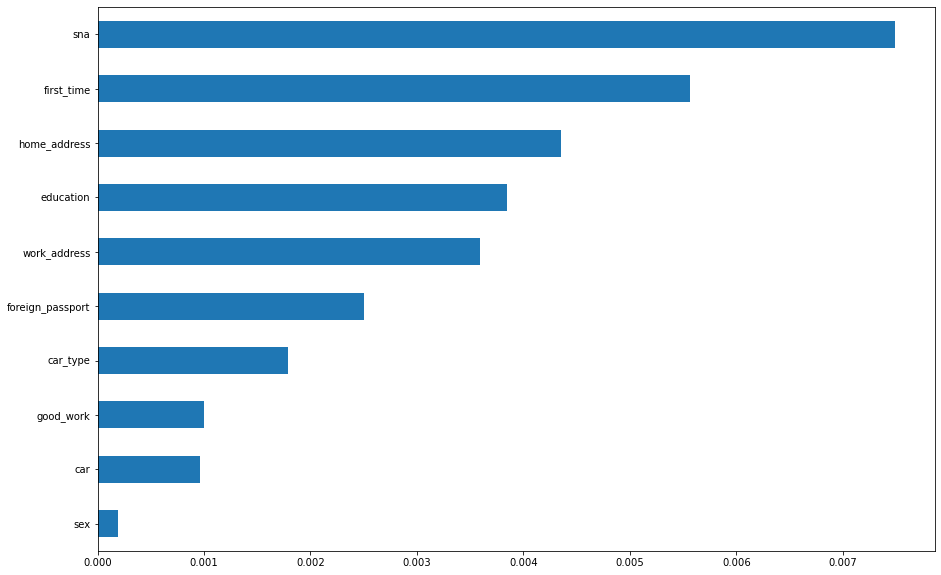

In [221]:
imp_cat = pd.Series(mutual_info_classif(data_temp[bin_cols + cat_cols],
                                        data_temp['default'],
                                        discrete_features=True),
                    index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

Самыми значимыми являются следующие признаки: sna, затем first_time, home_address и education.

## Стандартизация признаков

Для числовых признаков используем StandardScaler и для катрегориальных - OneHotEncoder

In [222]:
# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data_temp[num_cols].values) 

In [223]:
# Стандартизация категориальных переменных
X_cat = OneHotEncoder(sparse = False).fit_transform(data_temp[cat_cols].values)

In [224]:
X_cat.shape

(73739, 19)

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [225]:
# Объединяем

X = np.hstack([X_num, data_temp[bin_cols].values, X_cat])
Y = data_temp['default'].values

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [227]:
model = LogisticRegression(max_iter = 500)

model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# Оценка качества модели

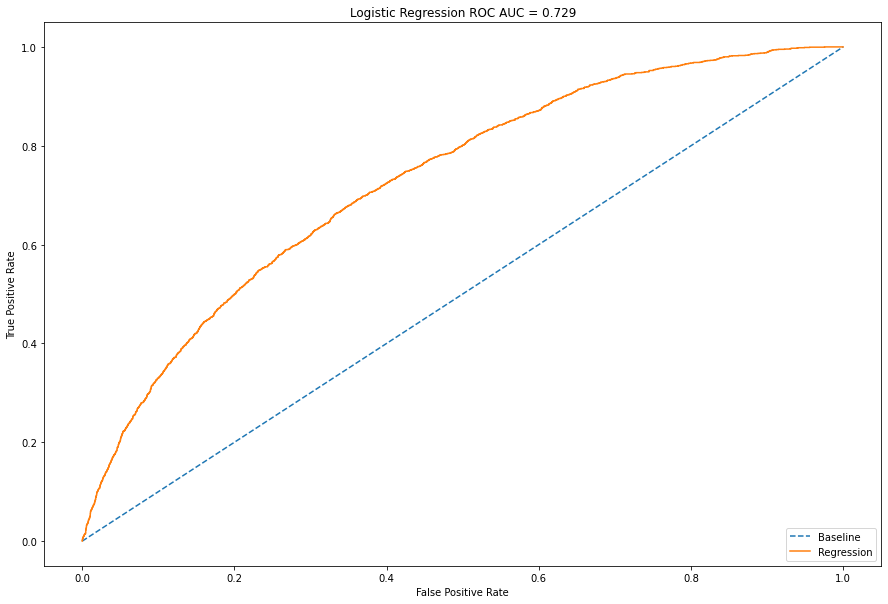

,naive
accuracy,0.873746
f1,0.049030
roc_auc,0.729323
confusion,"[[12838, 67], [1795, 48]]"


In [228]:
probs = model.predict_proba(X_test)
probs = probs[:,1]

metrics_naive = count_metrics(y_test, y_pred, probs)
data_metrics = pd.DataFrame.from_dict(metrics_naive, orient='index',columns = ['naive'])

show_roc_auc(y_test, probs)
display(data_metrics)

ROC AUC давольно высокая, но можно проверить другие параметры и улучшить ее с помощью гиперпараметров. 

Метрики показывают, что модель не очень хорошая.

Confusion matrix показывает следующее:
Недефолтных клиентов модель предсказывает хорошо: 12838 из 14633, т.е. 87.7 %, однако, дефолтных клиентов модель предсказывает не так хорошо: 48 из 115, т.е. 41.7%, что мне кажется плохим результатом (ошибка второго рода). Получается, наша модель будет выдавть кредит практически всем клиентам....Возможно, это связано с несбалансированностью нашей выборки. Попробуем обучить модель с гиперпараметрами.

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

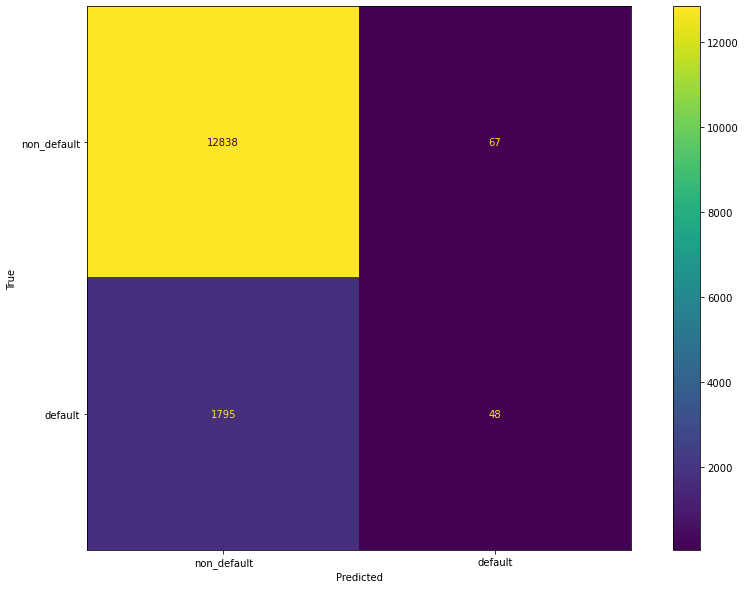

In [229]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

Проверю распределение целевой переменной

<AxesSubplot:xlabel='default', ylabel='count'>

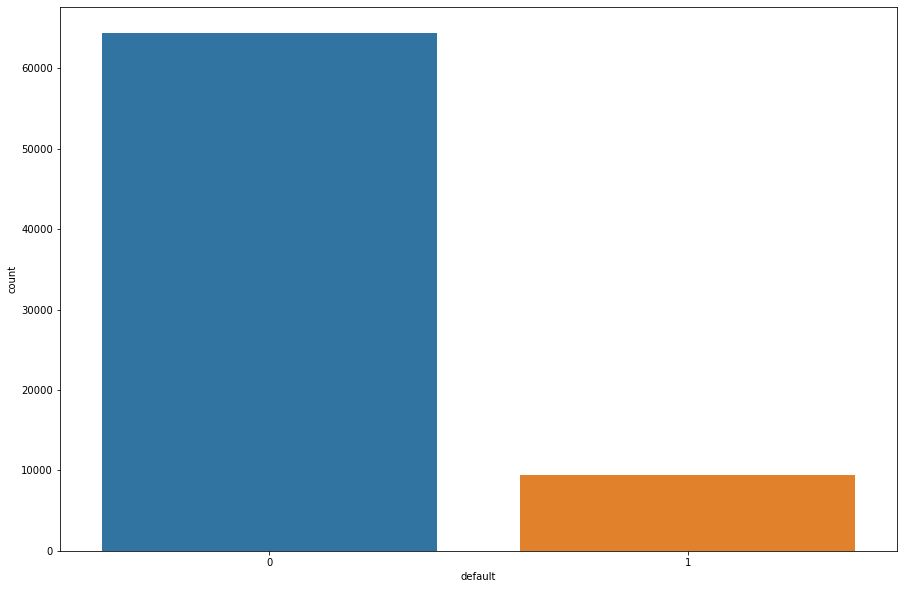

In [230]:
sns.countplot(x = data_temp['default'], data = data_temp)

Распределение целевой переменной несбалансировано. Попробую выровнять количество в дефолтной и недефолтной категориях

## Модель с underfitting

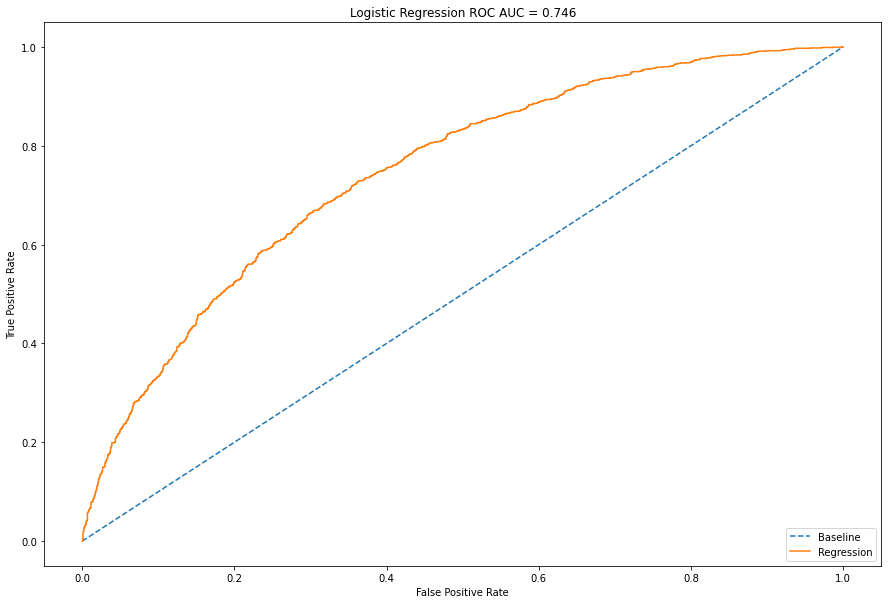

,naive,balanced
accuracy,0.873746,0.680544
f1,0.049030,0.674640
roc_auc,0.729323,0.746006
confusion,"[[12838, 67], [1795, 48]]","[[1309, 597], [600, 1241]]"


In [231]:
#выравниваю категории
classes = data_temp.default.value_counts(ascending=True)
minor = data_temp[data_temp.default == classes.index[0]]
other = data_temp[data_temp.default.isin(classes.index[1:])][:classes.iloc[0]]
data_train_balanced = pd.concat([other, minor])


# Стандартизация числовых переменных
X_num = StandardScaler().fit_transform(data_train_balanced[num_cols].values) 
# Стандартизация категориальных переменных
X_cat = OneHotEncoder(sparse = False).fit_transform(data_train_balanced[cat_cols].values)

X = np.hstack([X_num, data_train_balanced[bin_cols].values, X_cat])
Y = data_train_balanced['default'].values

# Делю данные на еще один тест и трейн
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

#само обучение
model_balanced = LogisticRegression(solver = 'liblinear')
model_balanced.fit(X_train, y_train)
y_pred = model_balanced.predict(X_test)
y_probs = model_balanced.predict_proba(X_test)[:,1]

#посмотрю метрики
metrics_balanced = count_metrics(y_test, y_pred, y_probs)
data_metrics['balanced'] = pd.Series(metrics_balanced)

show_roc_auc(y_test, y_probs)
display(data_metrics)

По confusion matrix видим, что теперь модель угадывает и дефолтных и недефолтных клиентов равномерно.

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

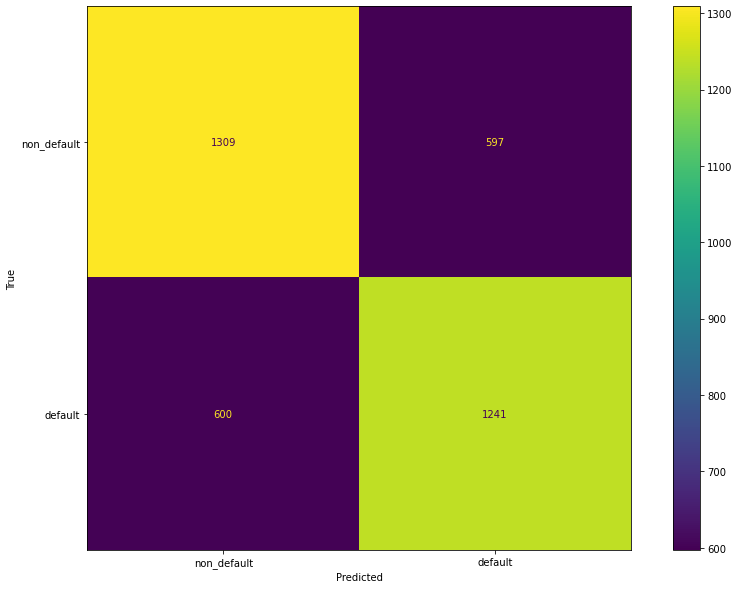

In [232]:
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['non_default','default'])
cmd.plot()
cmd.ax_.set(xlabel='Predicted', ylabel='True')

## Подбор гиперпараметров

In [233]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=42, max_iter=500, solver='liblinear')
model.fit(X_train, y_train)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.0


Обучаем модель с подобранными параметрами

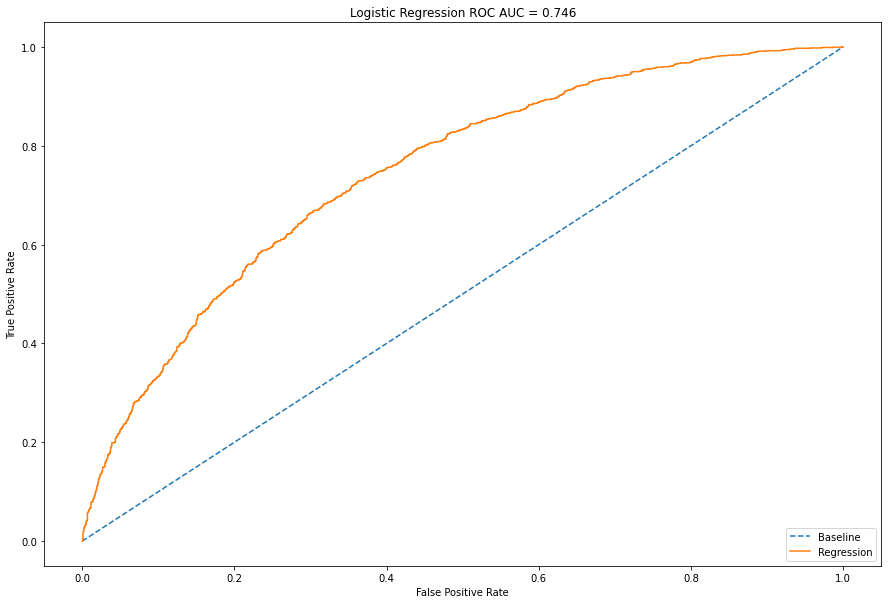

,naive,balanced,finish
accuracy,0.873746,0.680544,0.680544
f1,0.049030,0.674640,0.674640
roc_auc,0.729323,0.746006,0.746006
confusion,"[[12838, 67], [1795, 48]]","[[1309, 597], [600, 1241]]","[[1309, 597], [600, 1241]]"


In [234]:
model_finish = LogisticRegression(penalty='l2',
                                  C=1.0,
                                  max_iter=1000,
                                  solver='liblinear')
model_finish.fit(X_train, y_train)

y_pred = model_finish.predict(X_test)
y_probs = model_finish.predict_proba(X_test)[:, 1]

# Посмотрим метрики
metrics_finish = count_metrics(y_test, y_pred, y_probs)
data_metrics['finish'] = pd.Series(metrics_finish)

show_roc_auc(y_test, y_probs)
display(data_metrics)

После балансировки категорий метрики значительно улучшились. Для улучшения метрик можно было бы еще попробовать:

1. Поиграть с гиперпараметрами, тут использовалась только одна регуляризация 'l2'
1. Вернуться к анализу признаков и попробовать их изменить. Например, созданные числовые признаки с датами (сезон, день недели...) перевести в категориальные и сделать дамми переменные и т.д.
1. Изменить модель обучения и попробовать другие виды

# Submission

In [235]:
# проверю что требуется
sample_sub.sample(3)

,client_id,default
18250,4397,0.219419
2140,53479,0.716800
510,22585,0.845368


In [236]:
train_data = data.query('sample == 1').drop(['sample', 'client_id'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'client_id'], axis=1)

In [237]:
X_train = train_data.drop(['default'], axis=1)
y_train = train_data.default.values
X_test = test_data.drop(['default'], axis=1)

In [238]:
test_data.shape, train_data.shape, X_train.shape, y_train.shape, X_test.shape

((36349, 24), (73799, 24), (73799, 23), (73799,), (36349, 23))

In [239]:
final_model = LogisticRegression(random_state=42,
                                 C=1.0,
                                 class_weight='balanced',
                                 dual=False,
                                 fit_intercept=True,
                                 intercept_scaling=1,
                                 l1_ratio=None,
                                 multi_class='auto',
                                 n_jobs=None,
                                 penalty='l2',
                                 solver='liblinear',
                                 tol=0.001,
                                 verbose=0,
                                 warm_start=False,
                                 max_iter=1000)

final_model.fit(X_train, y_train)
y_pred_prob = final_model.predict_proba(X_test)[:, 1]
y_pred = final_model.predict(X_test)

In [240]:
submit = pd.DataFrame(test.client_id)
submit['default']=y_pred_prob
submit.to_csv('submission.csv', index=False)

In [241]:
submit.sample(3)

,client_id,default
21039,77845,0.834386
21206,53456,0.300844
35078,87651,0.668326
